## Word2vec model for GOBBYKID

In order to display values representing words similarities, we first need to create some models to train with respect to our corpora. Such models will be ablo to use <i>word embeddings</i> in order to retrieve similarities between the words of each corpus. This will be accomplished thanks to the mapping of such words into of feature-vectors.</br>
The aim of this section is to develop some different <i><u>word2vec</u></i> models, each with different parameters.</br>
At the end of the training session, we will qualitatively decide which one performs better in the definition of word similarities and save such model (obviously, the models will be two for each try: one for the female authors corpus and the other one for the male authors corpus). 

---------

### Setup

#### Install required libraries

To have an overview of the libraries used in this project, you can check the [README file](README.md).

Once followed the instructions provided in the above mentioned file, you can import the libraries, as well as the functions defined in the [normalizations functions file](normalization_functions.py).

In [1]:
from normalization_functions import *

---------

### Reading the corpora

Seen that the purpose of this project is the one defined in the [README file](README.md), we have obviously decided to train our model on the basis of the two corpora that we aim at analyzing.

In order to create a w2v model, we first need to create the two corpora for which we want to build the model, then we will store all the urls of the texts contained inside them into two different lists.</br>
Such lists will be passed as input to a function developed to store all the tokens of a corpus inside a list. During this step, texts will also need some preprocessing operation that will be performed by the same <span style="color:#89FC00"><i>list_builder</i></span> function, contained inside the [normalization functions file](normalization_functions.py), that will also create the two lists of which we were talking before.

In [2]:
f_directory = "assets/Raw corpora/F/"
m_directory = "assets/Raw corpora/M/"
f_corpus = create_corpus(f_directory)
m_corpus = create_corpus(m_directory)

In [3]:
# Female authors corpus
f_authors_texts = list()
for url in f_corpus.fileids():
    if url != '.DS_Store':
        f_authors_texts.append(f_directory+url)

# Male authors corpus
m_authors_texts = list()
for url in m_corpus.fileids():
    if url != '.DS_Store':
        m_authors_texts.append(m_directory+url)

These are the urls extracted:

In [4]:
print("URLS of female authors texts:", f_authors_texts, '\n')
print("URLS of male authors texts:", m_authors_texts, '\n')

URLS of female authors texts: ['assets/Raw corpora/F/1839_sinclair-holiday-house-a-series-of-tales.txt', 'assets/Raw corpora/F/1841_martineau-the-settlers-at-home.txt', 'assets/Raw corpora/F/1857_browne-grannys-wonderful-chair.txt', 'assets/Raw corpora/F/1857_tucker-the-rambles-of-a-rat.txt', 'assets/Raw corpora/F/1862_ewing-melchiors-dream-and-other-tales.txt', 'assets/Raw corpora/F/1869_ewing-mrs-overtheways-remembrances.txt', 'assets/Raw corpora/F/1869_ewing-the-land-of-lost-toys.txt', 'assets/Raw corpora/F/1870_ewing-the-brownies-and-other-tales.txt', 'assets/Raw corpora/F/1872_craik-the-adventure-of-a-brownie.txt', 'assets/Raw corpora/F/1872_de-la-ramee-a-dog-of-flanders.txt', 'assets/Raw corpora/F/1873_ewing-a-flat-iron-for-a-farthing.txt', 'assets/Raw corpora/F/1875_craik-the-little-lame-prince-and-his-traveling-cloack.txt', 'assets/Raw corpora/F/1876_ewing-jan-of-the-windmill.txt', 'assets/Raw corpora/F/1876_ewing-six-to-sixteen-a-story-for-girls.txt', 'assets/Raw corpora/F/187

Now, as we said above, we will go on by creating the two lists:

In [5]:
f_tokens = list_builder(f_authors_texts)

In [6]:
m_tokens = list_builder(m_authors_texts)

---------

### Models

Once we have the two lists, we need to initialize the two different models thanks to the Gensim library.</br>
Each model will be used for the respective corpus on which it has been trained.

<b><u>Model testing</u></b>

To this end, we will create six groups of models and see which between these will perform better.</br>
The parameters will be different for each group, and now we will provide a brief overiview of what we want to do.</br>
In the word2vec model we may use 2 different methodologies to retrieve/produce word embeddings:
- <span style="color:#EE6352">CBOW (Continuous Bag Of Words)</span> - this first methodology operates by trying to solve a sort of "fake problem": given a context, the model tries to predict a target missing word. This is the base on which the model is trained in CBOW;
- <span style="color:#EE6352">Skip Grams</span> - the methodologies operates in an opposite way, it tries to solve a similar problem but, this time, the input is the target word and the output will be its context.

These are two different ways to train a word2vec model.</br></br>
Together with these different ways to compute embeddings, we will try to change the <i>context-window size</i>, that is basically the amount of words that are part of the context we aim at analyzing (the size represents the amount of words on the left side and on the right side of the target word; e.g for a size of 3, the 3 words on the left and the 3 words on the right of a target word will be considered).</br>
The different window sizes are computed after reading the article [Dependency-Based Word Embeddings](https://levyomer.files.wordpress.com/2014/04/dependency-based-word-embeddings-acl-2014.pdf), which states that <i>larger windows tend to capture more topic/domain information, while smaller windows tend to capture more information about the word itself</i>.</br>
        To this end, we will produce three groups of models for each methodology, and these will have small window size, medium window size and large window size.

Finally, we will use a <i>vector_size=80</i> (it means we will consider 80 features to describe the dimension of each word), this choice is based on the size of our corpus.

<span style="color:#F0A202"><i>PAY ATTENTION: In order to use the "workers" parameter defined inside each w2v model object, you need first to install <b>Cython</b>. Such parameter operates by deciding how many core of the CPU will be used for operations concerning the model. If Cython is not installed, the model will use by default one single core, therefore the operations will take way too much time to be performed.</i></span>

-------

#### CBOW Models

<b><span style="color:#EE6352">Small window</span></b>

The first operation to perform is the construction of a model. </br>
Inside the model, some parameters can be specified. For instance, we will work only with:
- <i>window</i>: defines the window size;
- <i>min_count</i>: defines the minnimum length of sentences to be considered;
- <i>workers</i>: defines the CPU cores that will compute calculations for the model (my CPU has 8 cores, if you have a CPU with less cores, please modify this value);
- <i>sg</i>: can assume the value of 1 or 0 (the default value), if its value is 1, then it will use skip grams to train the model, if the value is 0 it will train the model on a CBOW approach.

In [7]:
f_sw_cbow_model = gensim.models.Word2Vec(
    window=3,
    min_count=2, #This parameter do not consider sentences with "x" words or less, where x is the integer value specified
    workers=8, #This parameter is intended for CPU cores, if you have a CPU with less than 8 cores please modify the value
    sg=0,
    vector_size=100
)

In [8]:
m_sw_cbow_model = gensim.models.Word2Vec(
    window=3,
    min_count=2,
    workers=8, 
    sg=0,
    vector_size=100
)

The next step consists in building <i>vocabularies</i>, that is a collection of all the single tokens for each one of our models.</br>
In order to build vocabularies we will use the <span style="color:#89FC00">build_vocab()</span> method, provided by Gensim.

In [9]:
f_sw_cbow_model.build_vocab(f_tokens, progress_per=1000)

In [10]:
m_sw_cbow_model.build_vocab(m_tokens, progress_per=1000)

-------

<b><span style="color:#EE6352">Medium window</span></b>

In [11]:
f_mw_cbow_model = gensim.models.Word2Vec(
    window=6,
    min_count=2, 
    workers=8,
    sg=0,
    vector_size=100
)

In [12]:
m_mw_cbow_model = gensim.models.Word2Vec(
    window=6,
    min_count=2,
    workers=8, 
    sg=0,
    vector_size=100
)

In [13]:
f_mw_cbow_model.build_vocab(f_tokens, progress_per=1000)

In [14]:
m_mw_cbow_model.build_vocab(m_tokens, progress_per=1000)

--------

<b><span style="color:#EE6352">Large window</span></b>

In [15]:
f_lw_cbow_model = gensim.models.Word2Vec(
    window=9,
    min_count=2, 
    workers=8, 
    sg=0,
    vector_size=100
)

In [16]:
m_lw_cbow_model = gensim.models.Word2Vec(
    window=9,
    min_count=2,
    workers=8,
    sg=0,
    vector_size=100
)

In [17]:
f_lw_cbow_model.build_vocab(f_tokens, progress_per=1000)

In [18]:
m_lw_cbow_model.build_vocab(m_tokens, progress_per=1000)

----------

#### Skip Gram Models

While CBOW model is better in capturing syntactic relationships, the Skip Gram model preforms better in extracting semantic relationships.

<b><span style="color:#EE6352">Small window</span></b>

In [19]:
f_sw_skip_model = gensim.models.Word2Vec(
    window=3,
    min_count=2,
    workers=8,
    sg=1,
    vector_size=100
)

In [20]:
m_sw_skip_model = gensim.models.Word2Vec(
    window=3,
    min_count=2,
    workers=8,
    sg=1,
    vector_size=100
)

In [21]:
f_sw_skip_model.build_vocab(f_tokens, progress_per=1000)

In [22]:
m_sw_skip_model.build_vocab(m_tokens, progress_per=1000)

-------

<b><span style="color:#EE6352">Medium window</span></b>

In [23]:
f_mw_skip_model = gensim.models.Word2Vec(
    window=6,
    min_count=2,
    workers=8,
    sg=1,
    vector_size=100
)

In [24]:
m_mw_skip_model = gensim.models.Word2Vec(
    window=6,
    min_count=2,
    workers=8, 
    sg=1,
    vector_size=100
)

In [25]:
f_mw_skip_model.build_vocab(f_tokens, progress_per=1000)

In [26]:
m_mw_skip_model.build_vocab(m_tokens, progress_per=1000)

--------

<b><span style="color:#EE6352">Large window</span></b>

In [27]:
f_lw_skip_model = gensim.models.Word2Vec(
    window=9,
    min_count=2, 
    workers=8,
    sg=1,
    vector_size=100
)

In [28]:
m_lw_skip_model = gensim.models.Word2Vec(
    window=9,
    min_count=2,
    workers=8,
    sg=1,
    vector_size=100
)

In [29]:
f_lw_skip_model.build_vocab(f_tokens, progress_per=1000)

In [30]:
m_lw_skip_model.build_vocab(m_tokens, progress_per=1000)

--------

### Train the models

The next step consists on training the different groups of models that we have built. We will do it thanks to the Gensim <span style="color:#89FC00">.train()</span> method.

<b><span style="color:#EE6352">Small window</span></b>

In [31]:
f_sw_cbow_model.train(f_tokens, total_examples=f_sw_cbow_model.corpus_count, epochs=f_sw_cbow_model.epochs)
m_sw_cbow_model.train(m_tokens, total_examples=m_sw_cbow_model.corpus_count, epochs=m_sw_cbow_model.epochs)

(6554064, 7630590)

In [32]:
f_sw_skip_model.train(f_tokens, total_examples=f_sw_skip_model.corpus_count, epochs=f_sw_skip_model.epochs)
m_sw_skip_model.train(m_tokens, total_examples=m_sw_skip_model.corpus_count, epochs=m_sw_skip_model.epochs)

(6552636, 7630590)

--------------

<b><span style="color:#EE6352">Medium window</span></b>

In [33]:
f_mw_cbow_model.train(f_tokens, total_examples=f_mw_cbow_model.corpus_count, epochs=f_mw_cbow_model.epochs)
m_mw_cbow_model.train(m_tokens, total_examples=m_mw_cbow_model.corpus_count, epochs=m_mw_cbow_model.epochs)

(6553110, 7630590)

In [34]:
f_mw_skip_model.train(f_tokens, total_examples=f_mw_skip_model.corpus_count, epochs=f_mw_skip_model.epochs)
m_mw_skip_model.train(m_tokens, total_examples=m_mw_skip_model.corpus_count, epochs=m_mw_skip_model.epochs)

(6552772, 7630590)

--------

<b><span style="color:#EE6352">Large window</span></b>

Maybe, this section provides the best output for our porject.

In [35]:
f_lw_cbow_model.train(f_tokens, total_examples=f_lw_cbow_model.corpus_count, epochs=f_lw_cbow_model.epochs)
m_lw_cbow_model.train(m_tokens, total_examples=m_lw_cbow_model.corpus_count, epochs=m_lw_cbow_model.epochs)

(6553729, 7630590)

In [36]:
f_lw_skip_model.train(f_tokens, total_examples=f_lw_skip_model.corpus_count, epochs=f_lw_skip_model.epochs)
m_lw_skip_model.train(m_tokens, total_examples=m_lw_skip_model.corpus_count, epochs=m_lw_skip_model.epochs)

(6553749, 7630590)

--------

### Comparison between models

<b><span style="color:#EE6352">Small window</span></b>

In [37]:
DataFrame(f_sw_cbow_model.wv.most_similar("marriage")).rename(columns={0:"Word", 1:"Vector similarity"})

,Word,Vector similarity
0,youth,0.994863
1,disappointment,0.994437
2,favorite,0.993046
3,chief,0.992898
4,fame,0.992635
5,favourite,0.992560
6,victuals,0.992186
7,gun,0.992161
8,nail,0.992087
9,christening,0.991959


In [38]:
DataFrame(m_sw_cbow_model.wv.most_similar("marriage")).rename(columns={0:"Word", 1:"Vector similarity"})

,Word,Vector similarity
0,adventures,0.966656
1,connexion,0.964009
2,ambition,0.959463
3,circumstance,0.957449
4,judgment,0.957383
5,motive,0.954708
6,winning,0.954381
7,cares,0.954273
8,responsibility,0.953902
9,failure,0.953111


In [39]:
DataFrame(f_sw_skip_model.wv.most_similar("marriage")).rename(columns={0:"Word", 1:"Vector similarity"})

,Word,Vector similarity
0,voyage,0.955601
1,influence,0.955467
2,expense,0.954396
3,sufferings,0.952205
4,illness,0.951700
5,behalf,0.951527
6,daughters,0.950617
7,reign,0.950324
8,Bevis,0.950216
9,charge,0.949966


In [40]:
DataFrame(m_sw_skip_model.wv.most_similar("marriage")).rename(columns={0:"Word", 1:"Vector similarity"})

,Word,Vector similarity
0,folly,0.893837
1,strict,0.892370
2,devoted,0.887794
3,judgment,0.882866
4,boyhood,0.880122
5,readers,0.878888
6,adventure,0.878506
7,relative,0.875955
8,circumstance,0.875437
9,consideration,0.873743


--------------

<b><span style="color:#EE6352">Medium window</span></b>

In [41]:
DataFrame(f_mw_cbow_model.wv.most_similar("marriage")).rename(columns={0:"Word", 1:"Vector similarity"})

,Word,Vector similarity
0,statement,0.995635
1,dreams,0.994348
2,admired,0.992216
3,joke,0.991709
4,property,0.991044
5,Captain,0.991033
6,experience,0.991010
7,staying,0.991005
8,history,0.990992
9,ended,0.990957


In [42]:
DataFrame(m_mw_cbow_model.wv.most_similar("marriage")).rename(columns={0:"Word", 1:"Vector similarity"})

,Word,Vector similarity
0,misfortune,0.958482
1,freedom,0.944985
2,society,0.943623
3,fate,0.941384
4,term,0.941252
5,teaching,0.941057
6,folly,0.940854
7,pleasures,0.939605
8,principles,0.939327
9,separation,0.939251


In [43]:
DataFrame(f_mw_skip_model.wv.most_similar("marriage")).rename(columns={0:"Word", 1:"Vector similarity"})

,Word,Vector similarity
0,voyage,0.946059
1,interview,0.940724
2,shown,0.936649
3,severe,0.934634
4,loss,0.933221
5,appetite,0.933074
6,consulted,0.931924
7,reign,0.931601
8,Brooke,0.930550
9,Dacrefield,0.928372


In [44]:
DataFrame(m_mw_skip_model.wv.most_similar("marriage")).rename(columns={0:"Word", 1:"Vector similarity"})

,Word,Vector similarity
0,devoted,0.877288
1,Beverley,0.870024
2,Colonel,0.869903
3,crime,0.868091
4,title,0.866762
5,parson,0.864355
6,Fuzby,0.861567
7,attachment,0.858103
8,youthful,0.855163
9,professional,0.854858


--------

<b><span style="color:#EE6352">Large window</span></b>

In [45]:
DataFrame(f_lw_cbow_model.wv.most_similar("marriage")).rename(columns={0:"Word", 1:"Vector similarity"})

,Word,Vector similarity
0,due,0.993112
1,greatly,0.992918
2,sons,0.992818
3,courage,0.992463
4,begun,0.992296
5,affection,0.992095
6,regard,0.992045
7,hopes,0.991801
8,skill,0.991682
9,ideas,0.991649


In [46]:
DataFrame(m_lw_cbow_model.wv.most_similar("marriage")).rename(columns={0:"Word", 1:"Vector similarity"})

,Word,Vector similarity
0,strict,0.945507
1,mama,0.942706
2,teaching,0.935985
3,cowardice,0.933188
4,confirmed,0.932639
5,liking,0.927924
6,claims,0.927791
7,sensible,0.927504
8,conditions,0.926955
9,blessing,0.925245


In [47]:
DataFrame(f_lw_skip_model.wv.most_similar("marriage")).rename(columns={0:"Word", 1:"Vector similarity"})

,Word,Vector similarity
0,interview,0.933006
1,benefit,0.926586
2,result,0.920223
3,Matilda's,0.919876
4,occurred,0.917671
5,cousins,0.916780
6,attending,0.916634
7,loss,0.912295
8,title,0.911759
9,Dacrefield,0.909110


In [48]:
DataFrame(m_lw_skip_model.wv.most_similar("marriage")).rename(columns={0:"Word", 1:"Vector similarity"})

,Word,Vector similarity
0,title,0.869416
1,Villiers,0.855650
2,devoted,0.850929
3,parents,0.849637
4,heir,0.847606
5,capacity,0.845645
6,worldly,0.845530
7,Fuzby,0.845451
8,Colonel,0.843176
9,strict,0.837228


--------

### Conclusions

Finally, once we have looked at all these models, we came out that for our kind of analysis it would be better to use a <span style="color:#F0A202"><i>CBOW based model</i></span> in order to highlight the syntactical similarities between words.

Moreover, for what concerns the window of words over which is better to train the model, we prefer to use a <span style="color:#F0A202"><i>medium window size</i></span> in order to find a balance between extremely contextual information and word-related information.

In order to maintain such models we will save them in the [Models directory](assets/Models/):

In [90]:
f_mw_cbow_model.save("assets/Models/F/f_mwskip.model")
m_mw_cbow_model.save("assets/Models/M/m_mwskip.model")

If you want to re-use the model you just need to load it thanks to the <span style="color:#89FC00">load()</span> method.</br>
```
    model = gensim.models.Word2Vec.load("model_path.model")
```

-----

In [49]:
a = m_lw_skip_model.wv["he"]
print(a.shape)


(100,)


<i>adding the positive vectors, subtracting the negative, then from that resulting position, listing the known-vectors closest to that angle</i>

In [91]:
# Load the model
model = gensim.models.Word2Vec.load('assets/Models/F/f_mwskip.model')

In [92]:
def pp(obj):
    print(DataFrame(obj)) 

def analogy(neg1, pos1, pos2):
    result = model.wv.most_similar(negative=[neg1], 
                                        positive=[pos1, pos2])
    tagged_keyword = pos_tag([pos1], tagset='universal')
    
    list_of_similar = list()
    for tup in result:
        list_of_similar.append(tup[0])
    tagged_list = pos_tagging(list_of_similar, True)
    for i in range(len(tagged_list)):
        if tagged_list[i][1] == tagged_keyword[0][1]:
            return tagged_list[i][0]
    return result[0][0]

words = ['soldier', 'sailor', 'king', 'captain', 'war', 'beard']
for_analogy = [analogy('man', word, 'woman') for word in words]
# --->  man : king :: woman : ?
# ---> king(pos1) - man(neg1) + woman(pos2) = ?
# ---> neg1 : pos1 :: pos2 : ?
#r = analogy('man', 'king', 'woman')
#print(r)
pp(zip(words,for_analogy))


         0          1
0  soldier      bride
1   sailor       card
2     king      widow
3  captain    labours
4      war  housemaid
5    beard      shawl


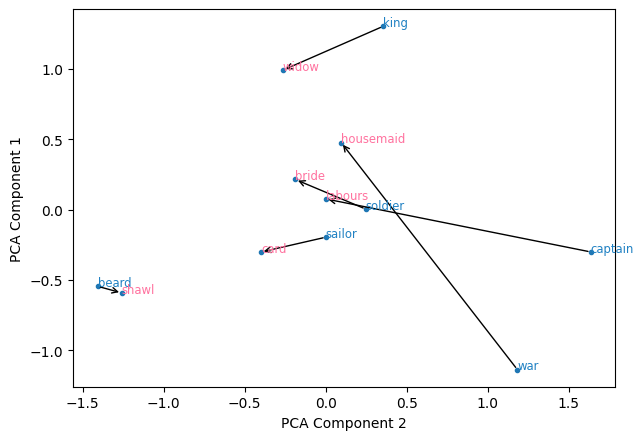

In [151]:
from turtle import dot
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def analogies_plot(list_of_words, model):
    pca = PCA(n_components=2)
    data = [model.wv[w] for w in list_of_words]
    data = pca.fit_transform(list_of_words)
    plt.figure(figsize=(7, 5), dpi=100)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.plot(data[:,0], data[:,1], '.')
    
    for i in range(len(data)//2):
        plt.annotate("",
                    xy=data[i],
                    xytext=data[i+len(data)//2],
                    arrowprops=dict(arrowstyle="<-",
                                    connectionstyle="arc3, rad=0",
                                    relpos=(1., 1.), fc='w')
            )
    for i in range(len(data)):
        if i < len(data)//2:
            plt.annotate(labels[i], xy=data[i], color='#2081C3',size='small')
        else:
            plt.annotate(labels[i], xy=data[i], color='#FF729F',size='small')
       
labels = words + for_analogy
data = [m_mw_skip_model.wv[w] for w in labels]
analogies_plot(data, labels)

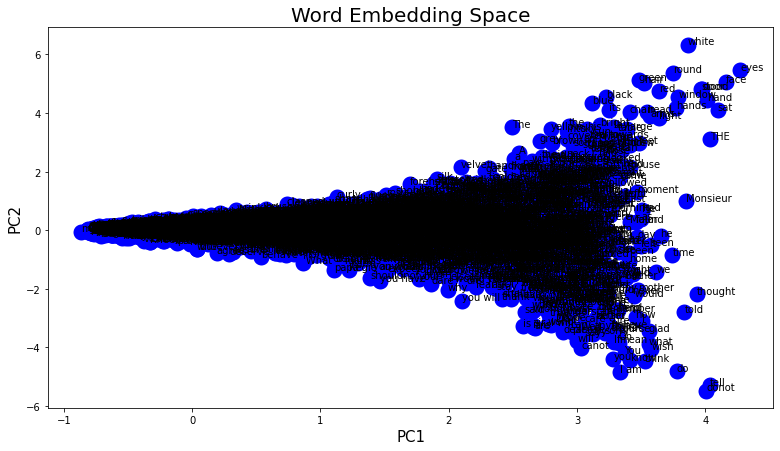

In [159]:
labels = words + for_analogy
data = [m_mw_skip_model.wv[w] for w in labels]

def plot_embedding_space(list_of_words, female_words=True): 
  plt.figure(figsize=(13,7))
  pca = PCA(n_components=2)
  data = [model.wv[w] for w in list_of_words]
  pca_data = pca.fit_transform(data)
  if female_words:
    plt.scatter(pca_data[:,0],pca_data[:,1],linewidths=10,color='#FEC9F1')
    plt.title("Word Embedding Space - Female related words",size=20)
  else:
    plt.scatter(pca_data[:,0],pca_data[:,1],linewidths=10,color='#A3C4BC')
    plt.title("Word Embedding Space - Male related words",size=20)
  plt.xlabel("PC1",size=12)
  plt.ylabel("PC2",size=12)
  #vocab=list(model.wv.key_to_index)
  for i, word in enumerate(pca_data):
    plt.annotate(word,xy=(pca_data[i,0],pca_data[i,1]))